In [12]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")
from pmdarima import auto_arima 
import pandas as pd 
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

matplotlib.rcParams['figure.figsize'] = (15, 8)

In [8]:
df = pd.read_csv('../datatest/monthly-car-sales.csv')

In [9]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [10]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)


<AxesSubplot:>

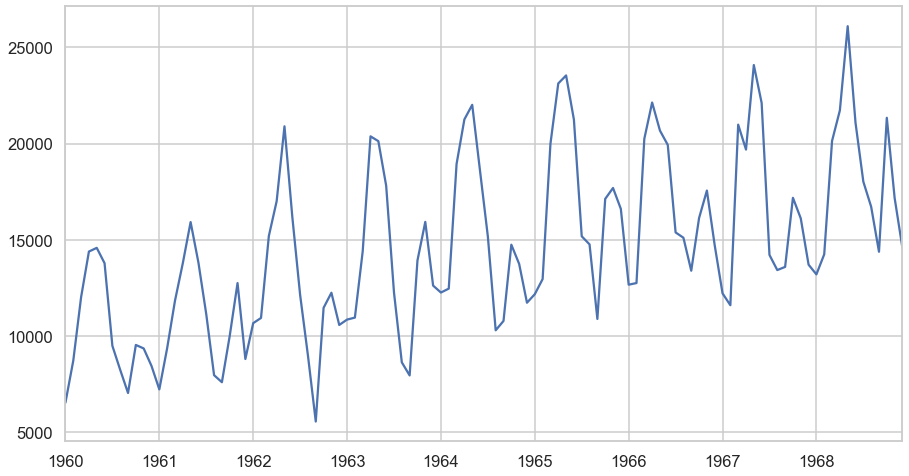

In [13]:
df['Sales'].plot()

Задание №1 
-------
Разложить на компоненты, используя функцию <code>seasonal_decompose</code>

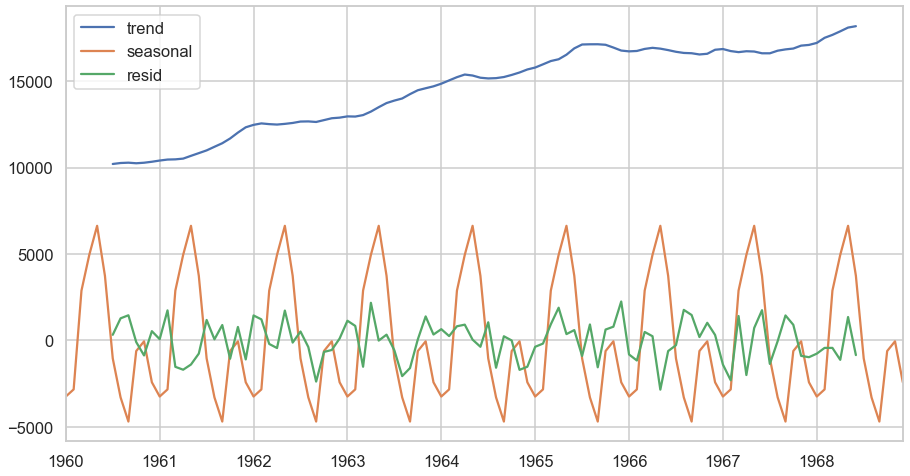

In [22]:
# your code
res = seasonal_decompose(df['Sales'], period=12)
res.trend.plot()
res.seasonal.plot()
res.resid.plot()
plt.legend(loc="upper left")
plt.show()

Проверим, является ли временной ряд стационарным. 

In [23]:
result = adfuller(df['Sales'])
print('p-value: %f' % result[1])

p-value: 0.663269


Ряд не стационарный, попробуем сделать одну дифференциацию.

In [24]:
df['diff'] = df['Sales'].diff()
df.dropna(inplace=True)

result = adfuller(df['diff'])
print('p-value: %f' % result[1])

p-value: 0.000000


<AxesSubplot:>

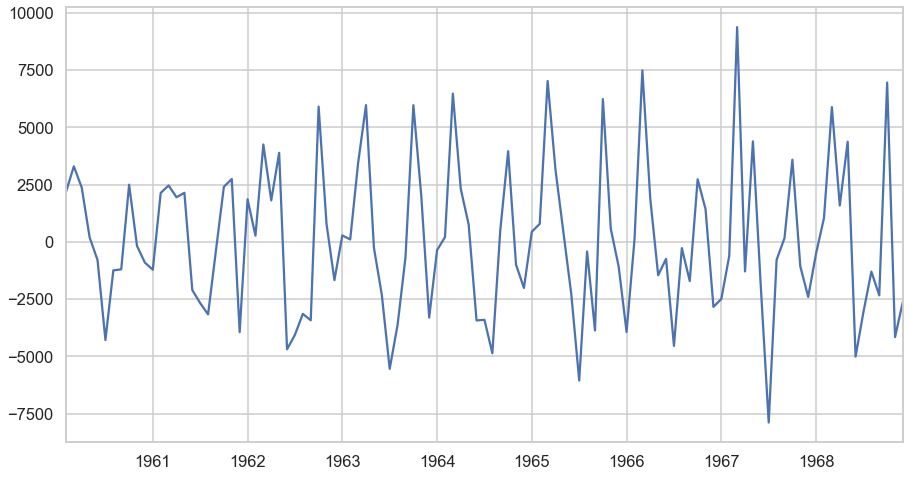

In [25]:
df['diff'].plot()

Задание №2
------
Сделать графики авто корреляции и часточной автокорреляции с помощью функций <code> plot_acf </code> и <code> plot_pacf </code>.

Если при использовании функции <code> plot_pacf </code> появляется ошибка <code>RuntimeWarning: invalid value encountered in sqrt</code> , можно изменить дефолтное значение метода, используемого для рассчета частичной автокорреляции. Почитать про методы можно почитать здесь:
<a>https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html</a>

Попробуйте использовать <code> method = 'ldadjusted' </code>

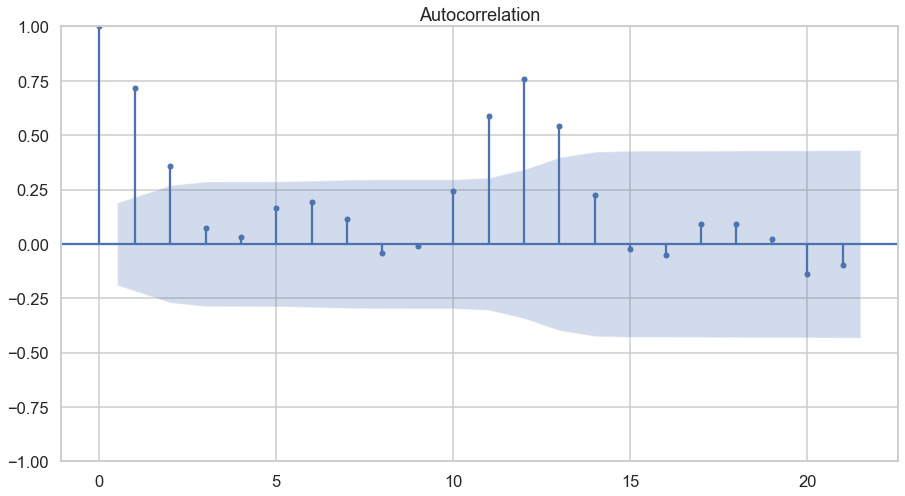

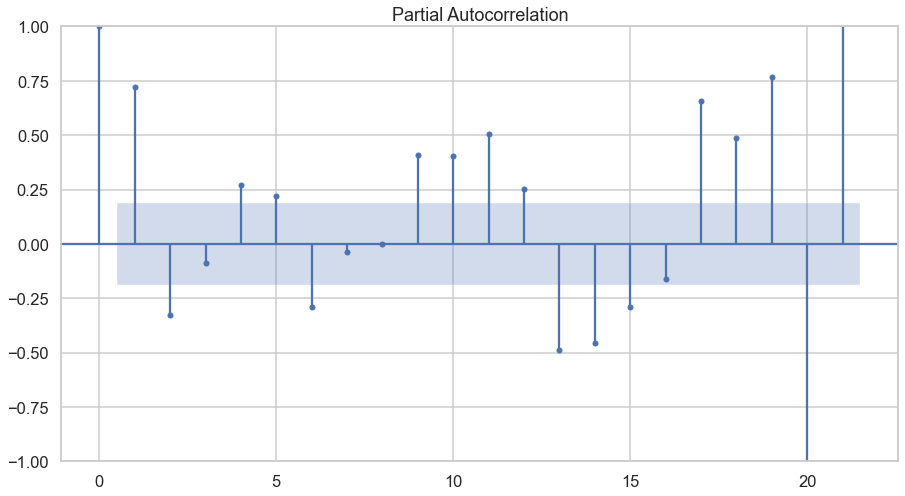

In [31]:
plot_acf(df['Sales']);
plot_pacf(df['Sales'], method='ldadjusted');

In [32]:
# split data into train and test

# what is the size of 80% ? 
size = int(len(df)*0.8)

# use 80% for train and 20% for test

train, test = df[0:size], df[size:]
print(f'Length of train is {len(train)} and lenght of test is {len(test)}')

Length of train is 85 and lenght of test is 22


In [33]:
model = ARIMA(train['Sales'], order=(2,1,2))
model_fit = model.fit(cov_type = 'approx')
preds = model_fit.forecast(len(test))

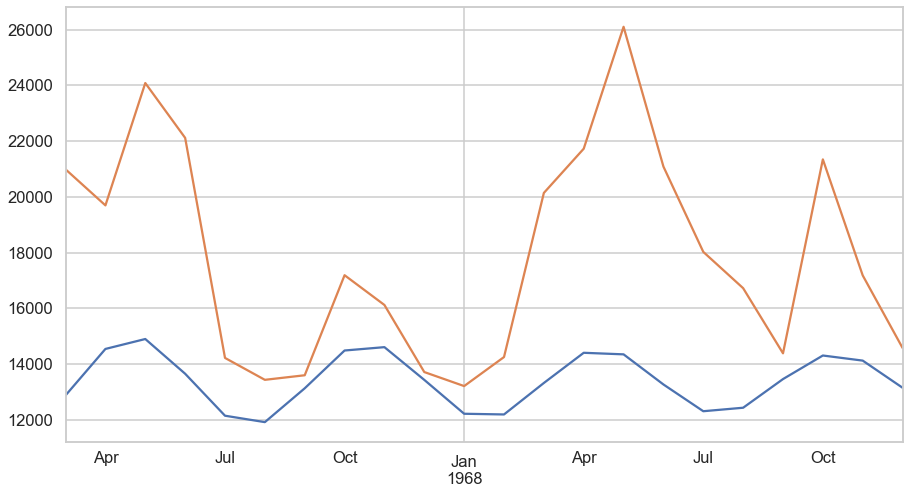

In [34]:
preds.plot()
test['Sales'].plot()
plt.show()

Задание №3
===
Используя <code>auto_arima</code> найти оптимальный набор параметров, натренировать на нем модель (на тренировочных данных) и сделать прогноз для теста. Сделать графики и посчитать качество предсказаний, используя метрики <code> r2_score </code> и <code> mean_absolute_error </code>.

In [13]:
# your code

In [38]:
sarima_model = auto_arima(train['Sales'],
                          start_p=0,start_q=0,max_p=12,max_q=5,start_d =0, max_d=12, m=12, seasonal=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   85
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -637.143
Date:                            Tue, 28 Jun 2022   AIC                           1288.286
Time:                                    23:33:03   BIC                           1304.319
Sample:                                         0   HQIC                          1294.675
                                             - 85                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    609.8223    322.562      1.891      0.059     -22.388    1242.032
ar.L1          0.2154      0.150      1.437      0.151      -0.078       0.509
ar.L2          0.3082      0.143      2.154      0.031       0.028       0.589
ar.L3         -0.1661      0.149     -1.113      0.266      -0.459       0.126
ar.S.L12      -0.1069      0.086     -1.241      0.215      -0.276       0.062
ar.S.L24       0.1195      0.103      1.162      0.245      -0.082       0.321
sigma2      2.412e+06   4.52e+05      5.330      0.000    1.52e+06     3.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.66
Prob(Q):                              0.75   Prob(JB):                         0.72
Heteroskedasticity (H):               1.56   Skew:                             0.23
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

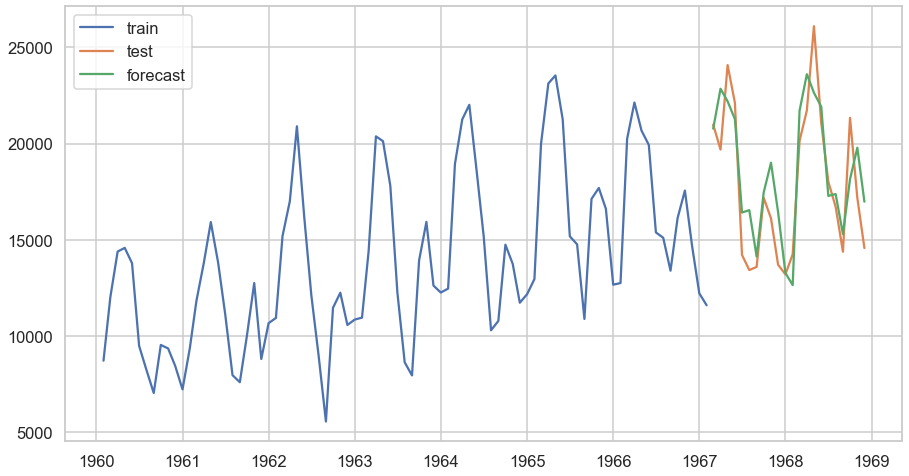

In [53]:
forecast = pd.DataFrame(sarima_model.predict(len(test)),index=test.index)
forecast.columns=['predictions']
# plt.figure()
plt.plot(train.Sales, label='train')
plt.plot(test.Sales, label='test')
plt.plot(forecast, label='forecast')
plt.legend(loc="upper left")